# **Spilios Spiliopoulos 4495**
# Set 2 Machine Learning CSE

# Its important to keep track the shapes of the arrays

* In every run of the code blocks, small modification might be needed in order to reshape properly the inputs
* That happens beacuse the PCA method may achieve different results during dimensions reduction 
* Check For "IMPORTANT NOTES" headers
* The current code works for M = 132

# In the zip folder, there is a python script that will help the user calculate the reshpae dimensions (if needed)
# That's because the PCA method outputs inconsistent number of reduced dimensions M. 

# Load the Data from the Fashion MNIST Dataset
* Set the train images
* Set the test images
* Reshape both to 1D array (784 1D Matrix for features instead of (28 , 28) 2D Array)
* That is required in order to use our machine learning models

In [160]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist

# Load Fashion MNIST data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Print the shape of the training data
print(train_images.shape)  # Output: (60000, 28, 28)
print(train_labels.shape)  # Output: (60000,)

# Reshape the data to 2D (d=784) 2D array needed for PCA
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

# Print the new shape of the training data 
print(train_images.shape)  # Output: (60000, 784)
print(train_labels.shape)  # Output: (60000,)

(60000, 28, 28)
(60000,)
(60000, 784)
(60000,)


# **Samples Selection**

# Select random samples of 1000 for each category
* Increase/Decrease the sample size (samples = ... ) for larger/smaller dataset 

# Check the "IMPORTANT NOTE" below in the code

In [167]:
#Import the random library  
import random

# Set random seed for reproducibility)
random.seed(42)

samples_train = 1000
sampled_images = []
sampled_labels = []

# Sample training data
sampled_train_images = []
sampled_train_labels = []

# Iterate over each category for training data
for category in range(10):  # There are 10 categories in Fashion MNIST
    # Find indices of data belonging to the current category
    # Get a list where the train label values 
    # (1D array meaning it contains just numbers of categories)
    # are the same as the current category.
    category_indices = np.where(train_labels == category)[0]

    # Randomly sample a subset of data from the current category
    sampled_indices = np.random.choice(category_indices, samples_train, replace=False)
    
    # Add the sampled data to the lists
    sampled_train_images.append(train_images[sampled_indices])
    sampled_train_labels.append(train_labels[sampled_indices])

# Concatenate the sampled training data from all categories
# Convert the list of np.array with each array containing 
# the sampled images and labels for a particular category. 
# To create a unified training dataset that contains all 
# the sampled images and labels across all categories, we  
# need to concatenate these lists of arrays into a single numpy array.
sampled_train_images = np.concatenate(sampled_train_images, axis=0)
sampled_train_labels = np.concatenate(sampled_train_labels, axis=0)

# Sample test data
samples_test = 200
sampled_test_images = []
sampled_test_labels = []

# Iterate over each category for test data
for category in range(10):  # There are 10 categories in Fashion MNIST
    # Find indices of data belonging to the current category
    category_indices = np.where(test_labels == category)[0]
    
    # Randomly sample a subset of data from the current category
    sampled_indices = np.random.choice(category_indices, samples_test, replace=False)
    
    # Add the sampled data to the lists
    sampled_test_images.append(test_images[sampled_indices])
    sampled_test_labels.append(test_labels[sampled_indices])

# Concatenate the sampled test data from all categories
sampled_test_images = np.concatenate(sampled_test_images, axis=0)
sampled_test_labels = np.concatenate(sampled_test_labels, axis=0)

# Print the size of the sampled datasets
print("Size of the sampled training set:", sampled_train_images.shape)
print("Size of the sampled training labels:", sampled_train_labels.shape)
print("Size of the sampled test set:", sampled_test_images.shape)
print("Size of the sampled test labels:", sampled_test_labels.shape)

Size of the sampled training set: (10000, 784)
Size of the sampled training labels: (10000,)
Size of the sampled test set: (2000, 784)
Size of the sampled test labels: (2000,)


# Standarize the data :
* Standarize the data and transform it to have a mean of 0 and a standard deviation of 1
* In order to pass it to the PCA
* Reduce Dimensions with the Principal Component Analysis (PCA) method

In [168]:
# Standardize the data
scaler = StandardScaler()
train_images_std = scaler.fit_transform(sampled_train_images)
# Uses the mean and standard deviation (or principal components) 
# calculated from the training data to standardize (or transform) the test data.
# That's why we dont use "fit_transform" on the test data.
test_images_std = scaler.transform(sampled_test_images)

print(train_images_std.shape)

# Apply PCA to retain 90% of the variance
pca = PCA(n_components=0.90)
train_images_pca = pca.fit_transform(train_images_std)
# Same reason 
test_images_pca = pca.transform(test_images_std)

# Get the dimension of the new feature space
M = train_images_pca.shape[1]

print("Original dimensions    : ", sampled_train_images.shape[1])
print("Reduced dimensions (M) : ", M)

(10000, 784)
Original dimensions    :  784
Reduced dimensions (M) :  132


**That means:** 

By retaining M = 132 components, we keep the dimensions that account for 90% of the total variance.

# If the Reduced Dimensions differ from M = 132
# We will need to adjust the **reshape_dims** variable later

# **AUTOENCODER**

# Auto-Encoder
* Consists of 2 parts: The Encoder and the Decoder
# Encoder
* Define Input Dimensions and input shape for the Encoder
* Initial Dimensions d = 784
* Encode from d to d/4 (196) dimensions
* Encode from d/4 to M (132) dimensions
# Decoder (Reconstruct the initial dimensions of the images)
* Decode from M (132) to d/4 (196)
* Decode from d/4 (196) to d

In [169]:
import keras
from keras import layers

# Parameters
input_dim = train_images_std.shape[1]  # d = 784
encoding_dim = M  # M = 132 (from question a)

# This is our input image
input_img = keras.Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
#encoded = layers.Dense(input_dim, activation='relu')(input_img)
encoded = layers.Dense(input_dim // 4, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
#decoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(input_dim // 4, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# Create Encoder and Decoder models seperatly (not needed ?)

In [170]:
# Encoder model
encoder = keras.Model(input_img, encoded)

# Decoder model
# Create input layer for decoder
decoder_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-2](decoder_input)
decoder_layer = autoencoder.layers[-1](decoder_layer)
# Create the decoder model
decoder = keras.Model(decoder_input, decoder_layer)


# Step 1: Encode Data with the Encoder Model to dimensions M = 132
train_images_encoder = encoder.predict(train_images_std)   # Encode training data
test_images_encoder  = encoder.predict(test_images_std)    # Encode test data

# Step 2: Decode Data with the Decoder Model to dimensions = d = 784
#train_images_decoder = decoder.predict(train_images_encoder) # Decode training data
#test_images_decoder = decoder.predict(test_images_encoder)   # Decode test data

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# This will be needed for Compute Purity Funciton and Clustering

In [171]:
print("Train images encoder shape: ",train_images_encoder.shape)
#print("Train images decoder shape: ",train_images_decoder.shape)

Train images encoder shape:  (10000, 132)


# Train the Auto-Encoder
The goal of the Auto-Encoder is:
* Reduce the dimensions of the images (Encoder)
* Reconstruct the images from the reduced dimensions to the original dimensions (Decoder)

For this reason the X_train,y_train/X_test,y_test are the same images (Targets are the same as the initial images)

In [172]:
print("Sampled Train images shape: ",sampled_train_images.shape)
print("Sampled Test  images shape: ",sampled_test_images.shape)

autoencoder.fit(sampled_train_images, sampled_train_images,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(sampled_test_images, sampled_test_images))

Sampled Train images shape:  (10000, 784)
Sampled Test  images shape:  (2000, 784)
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5857 - val_loss: 0.3924
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3779 - val_loss: 0.3475
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3396 - val_loss: 0.3272
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3219 - val_loss: 0.3173
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3116 - val_loss: 0.3184
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3103 - val_loss: 0.3079
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3067 - val_loss: 0.3049
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2998 - val_loss: 0.3020
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3005 - val_loss: 0.3004
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2971 - val_loss: 0.3029
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2972 - val_los

# Create the reconstructed images (predictions) of the Auto-Encoder
* The dimensions of the reconstructed images from the autoencoder (and the decoder) should be the same as the initial dimensions of the images (d = 784)
* Store those images to np.array

In [173]:
# Make predictions 
train_images_autoencoder = autoencoder.predict(train_images_std)
test_images_autoencoder = autoencoder.predict(test_images_std)

# Print the model summary
autoencoder.summary()

print("Original dimension:", train_images_std.shape[1])
print("Autoencoder output shape:", train_images_autoencoder.shape[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 196)                 │         153,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 132)                 │          26,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 196)                 │          26,068 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 784)                 │         154,448 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,142 (4.12 MB)

 Trainable params: 360,380 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 720,762 (2.75 MB)

Original dimension: 784
Autoencoder output shape: 784


In [197]:
print("Train images auto-encoder shape : ", train_images_autoencoder.shape)
print("Train images auto-encoder type  : ", type(train_images_autoencoder))

Train images auto-encoder shape :  (10000, 784)
Train images auto-encoder type  :  <class 'numpy.ndarray'>


# Use the CNN from Set 1:
* This CNN had the most accuracy and validation accuracy in the previous set of exercises (Set 1)
* As input, a CNN takes tensors of shape (image_height, image_width, color_channels) so we need to reshape our M dimension 1D array to 2D (image_height, image_width)
* No need for color_channels because our images are grayscaled
* (d = 132) 1D Array can be reshaped to (12, 11) 2D Array

In [198]:
print(train_images_pca.shape)

(10000, 132)


# Important Note
* At this point we need define the correct 2D Matrix in order to convert the images
* Modify the **reshape_dims** variable here if M != 132
* We need to calculate two numbers: **x,y so that M = x*y**
  
**Solution 1**:
* Use the **find_primitives.py** python script in order to find the x,y
  
**Solution 2**:
* **Uncomment** the following part of the code below in order to reshpae every time (12,11) dimensions

**Solution 3**:
* Run the **'Samples Selection'** part of the code again (in order to achieve different results from the PCA Method)

In [199]:
import numpy as np
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

reshape_dims = (12, 11)
train_images_pca_cnn = train_images_pca
test_images_pca_cnn = test_images_pca

##########################################################################################################################################
# This code is for custom dimensions #

# Choose dimensions for reshaping
#reshape_dims = (11, 13)  # Dimensions to reshape PCA output

# Ensure the new shape fits the total number of features
#num_features = np.prod(reshape_dims)
#print(num_features)
#print(train_images_pca.shape[1])
#if num_features > train_images_pca.shape[1]:
    # If reshape dims have more features, pad the PCA output with zeros
#    train_images_pca_cnn = np.pad(train_images_pca_cnn, ((0, 0), (0, num_features - train_images_pca_cnn.shape[1])), 'constant')
#    test_images_pca_cnn = np.pad(test_images_pca_cnn, ((0, 0), (0, num_features - test_images_pca_cnn.shape[1])), 'constant')
#elif num_features < train_images_pca.shape[1]:
    # If reshape dims have fewer features, truncate the PCA output
#    train_images_pca_cnn = train_images_pca_cnn[:, :num_features]
#    test_images_pca_cnn = test_images_pca_cnn[:, :num_features]
##########################################################################################################################################

# Reshape data to fit CNN input
train_images_cnn = train_images_pca_cnn.reshape(-1, *reshape_dims, 1)
test_images_cnn = test_images_pca_cnn.reshape(-1, *reshape_dims, 1)
print("Train images before reshape for CNN: ",train_images_pca_cnn.shape)
print("Train images after  reshape for CNN: ",train_images_cnn.shape)

Train images before reshape for CNN:  (10000, 132)
Train images after  reshape for CNN:  (10000, 12, 11, 1)


# Define the Model (Exact same with Set 1)

Total number of parameters in the model: 115376
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3545 - loss: 1.9236 - val_accuracy: 0.7365 - val_loss: 0.8197
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6736 - loss: 0.9402 - val_accuracy: 0.7920 - val_loss: 0.6042
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7237 - loss: 0.7690 - val_accuracy: 0.8110 - val_loss: 0.5263
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7686 - loss: 0.6560 - val_accuracy: 0.8305 - val_loss: 0.4869
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7953 - loss: 0.5837 - val_accuracy: 0.8340 - val_loss: 0.4647
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8017 - loss: 0.5426 - val_accuracy: 0.8435 - val_loss: 0.4486
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8207 - loss: 0.5041 - val_accuracy: 0.8500 - val_loss: 0.4325
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 

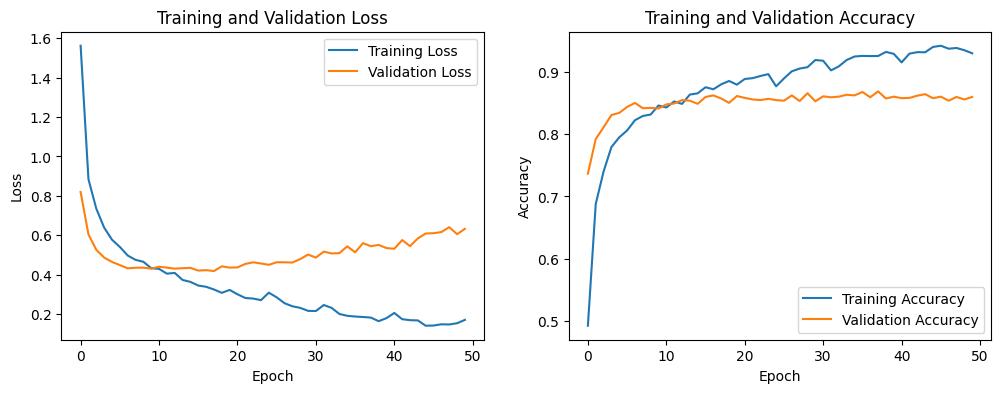

In [200]:
# Define the CNN model
model = Sequential([
    Input(shape=(reshape_dims[0], reshape_dims[1], 1)),  # Update input shape
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

# Total number of parameters in the model
num_parameters = model.count_params()
print("Total number of parameters in the model:", num_parameters)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images_cnn, sampled_train_labels, epochs=50, batch_size=256, validation_data=(test_images_cnn, sampled_test_labels))


# Extract final accuracy from history object
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)

# Plot the loss function and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

 # We note that we achieved better Validation Accuracy 
 # with the reduced data dimensions (M = 132) 

In [201]:
print("train_images_pca_cnn (shape): {}".format(train_images_pca_cnn.shape))
print("test_images_pca_cnn (shape): {}".format(test_images_pca_cnn.shape))
print("train_images_autoencoder (shape): {}".format(train_images_autoencoder.shape))
print("test_images_autoencoder (shape): {}".format(test_images_autoencoder.shape))
print("train_images_pca (shape): {}".format(train_images_pca.shape))
print("test_images_pca (shape): {}".format(test_images_pca.shape))

train_images_pca_cnn (shape): (10000, 132)
test_images_pca_cnn (shape): (2000, 132)
train_images_autoencoder (shape): (10000, 784)
test_images_autoencoder (shape): (2000, 784)
train_images_pca (shape): (10000, 132)
test_images_pca (shape): (2000, 132)


# Find the optimal K value for PCA, Auto-Encoder and Encoder train images

With K-Means algorithm:
* Compute the silhoutte score for each K (range from 10 to 20) number of points in order to identify the label of the current element
* Plot the Values of the silhoutte scores for all K values for both PCA and Auto-Encoder

**Silhouette scores generally range from -1 to 1, where:**

* A score close to 1 indicates that the samples are well-clustered, meaning they are far from the neighboring clusters.
* A score around 0 indicates that the samples are on or very close to the decision boundary between two neighboring clusters.
* A score close to -1 indicates that the samples might have been assigned to the wrong clusters.

Starting...
This might take a while...
Done for PCA
Done for Auto-Encoder
Done for Encoder


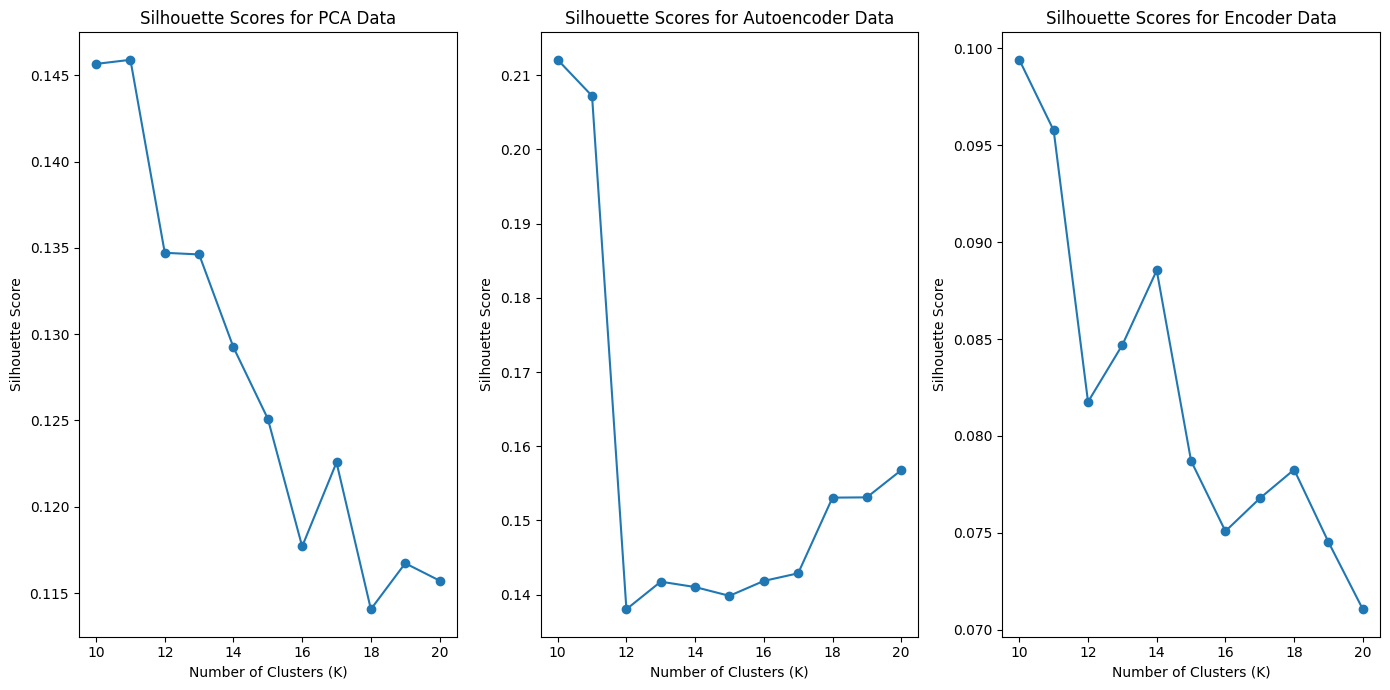

In [202]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define a range for K
K_range = range(10, 21)
K_values_pca = []
K_values_autoencoder = []
K_values_encoder = []

# Function to perform K-Means clustering and compute silhouette scores
def compute_silhouette_scores(data, K_range, K_values):
    silhouette_scores = []
    for K in K_range:
        kmeans = KMeans(n_clusters=K, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
        K_values.append(K)
    return silhouette_scores
print("Starting...")
print("This might take a while...")

# Compute silhouette scores for PCA data
silhouette_scores_pca = compute_silhouette_scores(train_images_pca, K_range, K_values_pca)
print("Done for PCA")

# Compute silhouette scores for Auto-Encoder data
silhouette_scores_autoencoder = compute_silhouette_scores(train_images_autoencoder, K_range, K_values_autoencoder)
print("Done for Auto-Encoder")

# Compute silhouette scores for Encoder data
silhouette_scores_encoder = compute_silhouette_scores(train_images_encoder, K_range, K_values_encoder)
print("Done for Encoder")

# Plotting the silhouette scores
plt.figure(figsize=(14, 7))

plt.subplot(1, 3, 1)
plt.plot(K_range, silhouette_scores_pca, marker='o')
plt.title('Silhouette Scores for PCA Data')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(K_range, silhouette_scores_autoencoder, marker='o')
plt.title('Silhouette Scores for Autoencoder Data')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 3)
plt.plot(K_range, silhouette_scores_encoder, marker='o')
plt.title('Silhouette Scores for Encoder Data')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Automatically retrieve the optimal value for the PCA, Auto-Encoder and Encoder Models

In [203]:
print("Maximum Silhouette score for the PCA          : ",max(silhouette_scores_pca))
print("Maximum Silhouette score for the Auto-Encoder : ",max(silhouette_scores_autoencoder))
print("Maximum Silhouette score for the Encoder      : ",max(silhouette_scores_encoder))
print("Index position for the PCA          : ",silhouette_scores_pca.index(max(silhouette_scores_pca)))
print("Index position for the Auto-Encoder : ",silhouette_scores_autoencoder.index(max(silhouette_scores_autoencoder)))
print("Index position for the      Encoder : ",silhouette_scores_encoder.index(max(silhouette_scores_encoder)))
print("K_values for PCA         : ",K_values_pca)
print("K_values for Autoencoder : ",K_values_autoencoder)
print("K_values for Autoencoder : ",K_values_encoder)

Maximum Silhouette score for the PCA          :  0.14589098
Maximum Silhouette score for the Auto-Encoder :  0.21205586
Maximum Silhouette score for the Encoder      :  0.09941038
Index position for the PCA          :  1
Index position for the Auto-Encoder :  0
Index position for the      Encoder :  0
K_values for PCA         :  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
K_values for Autoencoder :  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
K_values for Autoencoder :  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [204]:
optimal_K_pca = K_values_pca[silhouette_scores_pca.index(max(silhouette_scores_pca))]
optimal_K_autoencoder = K_values_autoencoder[silhouette_scores_autoencoder.index(max(silhouette_scores_autoencoder))]
optimal_K_encoder = K_values_encoder[silhouette_scores_encoder.index(max(silhouette_scores_encoder))]
print("Optimal K value for PCA          : ",optimal_K_pca)
print("Optimal K value for Auto-Encoder : ",optimal_K_autoencoder)
print("Optimal K value for      Encoder : ",optimal_K_encoder)

Optimal K value for PCA          :  11
Optimal K value for Auto-Encoder :  10
Optimal K value for      Encoder :  10


# Perform K-Means Clustering

In [205]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Optimal number of clusters based on silhouette scores
optimal_K_pca = K_values_pca[silhouette_scores_pca.index(max(silhouette_scores_pca))]
optimal_K_autoencoder = K_values_autoencoder[silhouette_scores_autoencoder.index(max(silhouette_scores_autoencoder))]
optimal_K_encoder = K_values_encoder[silhouette_scores_encoder.index(max(silhouette_scores_encoder))]

# K-Means clustering for PCA data
kmeans_pca = KMeans(n_clusters=optimal_K_pca, random_state=42)
kmeans_pca.fit(train_images_pca)
centers_pca = kmeans_pca.cluster_centers_

# K-Means clustering for Autoencoder data
kmeans_autoencoder = KMeans(n_clusters=optimal_K_autoencoder, random_state=42)
kmeans_autoencoder.fit(train_images_autoencoder)
centers_autoencoder = kmeans_autoencoder.cluster_centers_

# K-Means clustering for Autoencoder data
kmeans_encoder = KMeans(n_clusters=optimal_K_encoder, random_state=42)
kmeans_encoder.fit(train_images_encoder)
centers_encoder = kmeans_encoder.cluster_centers_

# The number of centers should be the same as the optimal K_value for each method respectively

In [206]:
print("Centers PCA          shape: ",centers_pca.shape)
print("Centers Auto-Encoder shape: ",centers_autoencoder.shape)
print("Centers Auto-Encoder shape: ",centers_encoder.shape)
print("PCA object: ",pca)
print("PCA type  : ",type(pca))

Centers PCA          shape:  (11, 132)
Centers Auto-Encoder shape:  (10, 784)
Centers Auto-Encoder shape:  (10, 132)
PCA object:  PCA(n_components=0.9)
PCA type  :  <class 'sklearn.decomposition._pca.PCA'>


# Reconstruct Images
We need to reshape the images to their initial dimensions (2D Array (28,28))
* For PCA object we call the inverse_transform() method (PCA Method generally keeps the information for the data and its original shape as opposed to the other methods)
* For the autoencoder we have to use the scaler to inverse_transform
* For the Encoder, we just have to use the Decoder on top of the Encoder

# PCA

In [207]:
# Inverse transform the PCA centers to the original space
pca_centers_original = pca.inverse_transform(centers_pca)
print("(1D Matix) Tranformed Images from Centers for PCA: ", pca_centers_original.shape)
pca_centers_images = pca_centers_original.reshape((optimal_K_pca, 28, 28))
print("(2D Matix) Tranformed Images from Centers for PCA :", pca_centers_images.shape)

(1D Matix) Tranformed Images from Centers for PCA:  (11, 784)
(2D Matix) Tranformed Images from Centers for PCA : (11, 28, 28)


# Auto-Encoder

In [208]:
# Inverse transform the Auto-Encoder centers to the original space 
# with Standard Scaler
autoencoder_centers_original = scaler.inverse_transform(centers_autoencoder)
print("(1D Matix) Tranformed Images from Centers for Auto-Encoder: ", autoencoder_centers_original.shape)
# Reshape each center into a 28x28 image
autoencoder_centers_images = np.array([center.reshape(28, 28) for center in autoencoder_centers_original])
print("(2D Matix) Tranformed Images from Centers for Auto-Encoder: ", autoencoder_centers_images.shape)

(1D Matix) Tranformed Images from Centers for Auto-Encoder:  (10, 784)
(2D Matix) Tranformed Images from Centers for Auto-Encoder:  (10, 28, 28)


# Encoder

In [209]:
print("Encoder centers shape: ",centers_encoder.shape)

Encoder centers shape:  (10, 132)


In [210]:
# Use the Decoder model in order to decode the images after clusterring of the encoded images (because the dimensions for the encoder are M = 132)
# The dimensions fitted for the first scaller are d = 784
decoded_centers = decoder.predict(centers_encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [211]:
print("Decoder centers shape: ",decoded_centers.shape)

Decoder centers shape:  (10, 784)


In [214]:
# Reshape each center into a 28x28 image
encoder_centers_images = np.array([center.reshape(28, 28) for center in decoded_centers])
print("(2D Matix) Tranformed Images from Centers for Encoder: ", encoder_centers_images.shape)

(2D Matix) Tranformed Images from Centers for Encoder:  (10, 28, 28)


# At this point, we are ready to plot the images from both methods
########################################################################################################
# Every Array is in the form of 28 * 28 dimensions

In [216]:
print("(2D Matix) Tranformed Images from Centers for         PCA : ", pca_centers_images.shape)
print("(2D Matix) Tranformed Images from Centers for Auto-Encoder: ", autoencoder_centers_images.shape)
print("(2D Matix) Tranformed Images from Centers for      Encoder: ", encoder_centers_images.shape)

(2D Matix) Tranformed Images from Centers for         PCA :  (11, 28, 28)
(2D Matix) Tranformed Images from Centers for Auto-Encoder:  (10, 28, 28)
(2D Matix) Tranformed Images from Centers for      Encoder:  (10, 28, 28)


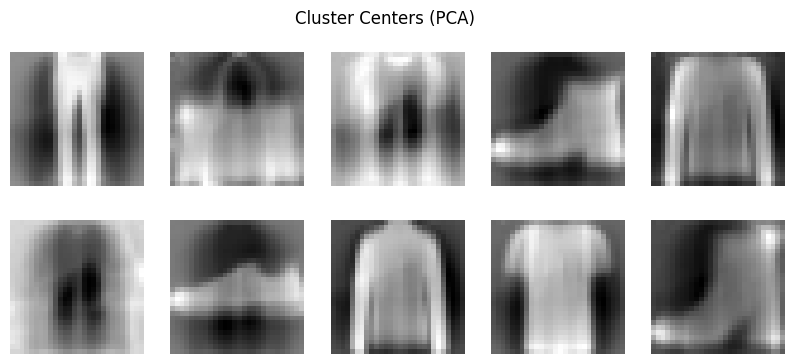

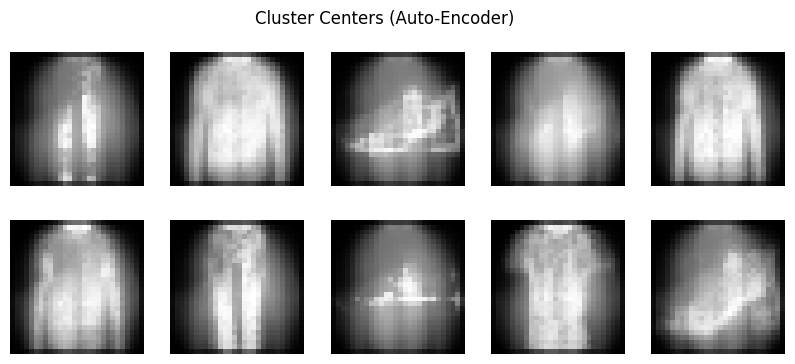

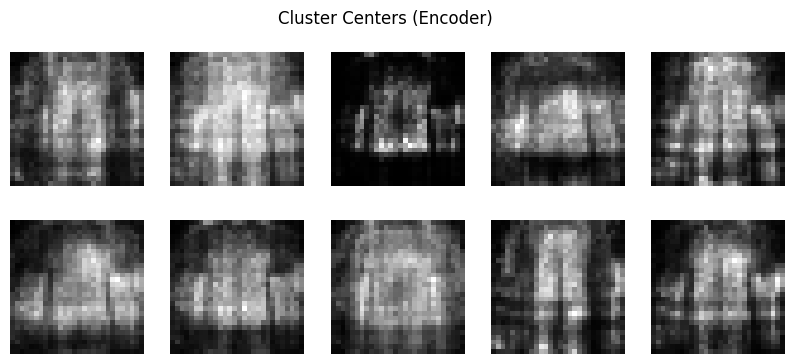

In [217]:
# Function to plot images
def plot_cluster_centers(images, title):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()




# Plot the PCA cluster centers
plot_cluster_centers(pca_centers_images, 'Cluster Centers (PCA)')

# Plot the Autoencoder cluster centers
plot_cluster_centers(autoencoder_centers_images, 'Cluster Centers (Auto-Encoder)')

# Plot the Encoder cluster centers
plot_cluster_centers(encoder_centers_images, 'Cluster Centers (Encoder)')

# Purity 

In [218]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [219]:
print("PCA          centers images shape : ",pca_centers_images.shape)
print("Auto-Encoder centers images shape : ",autoencoder_centers_images.shape)
print("Original Train images shape       : ",sampled_train_images.shape)
print("Original Test  images shape       : ",sampled_test_images.shape)
print("Original Train images shape  (std): ",train_images_std.shape)
print("Original Test  images shape: (std): ",test_images_std.shape)

PCA          centers images shape :  (11, 28, 28)
Auto-Encoder centers images shape :  (10, 28, 28)
Original Train images shape       :  (10000, 784)
Original Test  images shape       :  (2000, 784)
Original Train images shape  (std):  (10000, 784)
Original Test  images shape: (std):  (2000, 784)


# Ensure that the values of the arrays are on the same scale 
# In this case we will compare the std's of the PCA and Auto-Encoder values with the original std values

# Correct Data Shapes for compute_purity
* PCA Data: The shape should be (number_of_samples, number_of_principal_components)
* Auto-Encoder Data: The shape should be (number_of_samples, number_of_initial_dimensions) (because the autoencoder uses the decoder to reconstruct the initial input shape)
* Encoder Data: The shape should be (number_of_samples, number_of_encoded_dimensions)

In [220]:
print("PCA          train images shape: ",train_images_pca.shape)
print("Encoded      train images shape: ",train_images_encoder.shape)
print("Auto-Encoder train images shape: ",train_images_autoencoder.shape)
print("Sampled      train labels shape: ",sampled_train_labels.shape)

PCA          train images shape:  (10000, 132)
Encoded      train images shape:  (10000, 132)
Auto-Encoder train images shape:  (10000, 784)
Sampled      train labels shape:  (10000,)


In [221]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from collections import Counter



# Purity Function
def compute_purity(X, y, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    clusters = kmeans.labels_
    
    majority_sum = 0
    for i in range(n_clusters):
        cluster_indices = np.where(clusters == i)[0]
        true_labels = y[cluster_indices]
        most_common_label, count = Counter(true_labels).most_common(1)[0]
        majority_sum += count
    
    purity = majority_sum / len(y)
    return purity

X_pca = train_images_pca
X_encoder = train_images_encoder
X_autoencoder = train_images_autoencoder
y = sampled_train_labels

# Calculate Purity
purity_pca = compute_purity(X_pca, y, optimal_K_pca)
purity_autoencoder = compute_purity(X_autoencoder, y, optimal_K_autoencoder)
purity_encoder = compute_purity(X_encoder, y, optimal_K_autoencoder)

print(f"Purity for PCA         dataset: {purity_pca:.4f}")
print(f"Purity for Autoencoder dataset: {purity_autoencoder:.4f}")
print(f"Purity for Encoder     dataset: {purity_encoder:.4f}")

Purity for PCA         dataset: 0.5649
Purity for Autoencoder dataset: 0.4490
Purity for Encoder     dataset: 0.5122


# F-Measure

In [222]:
from sklearn.metrics import confusion_matrix

# F-Measure Function
def compute_f_measure(cluster_labels, true_labels, num_clusters):
    total_f_measure = 0
    r=0 
    
    for cluster in range(num_clusters):
        # Get indices of data points in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        # Get the values (labels) of those indices
        cluster_true_labels = true_labels[cluster_indices]
        
        # Determine the majority class in the cluster
        majority_class = np.bincount(cluster_true_labels).argmax()
        
        # Calculate TP, FP, and FN
        TP = np.sum(cluster_true_labels == majority_class)
        FP = np.sum(cluster_true_labels != majority_class)
        FN = np.sum((true_labels == majority_class) & (cluster_labels != cluster))
        
        # Precision and Recall
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # F-measure
        if precision + recall > 0:
            f_measure = 2 * (precision * recall) / (precision + recall)
        else:
            f_measure = 0
        
        total_f_measure += f_measure

    return total_f_measure

# K-means clustering on PCA data
num_clusters_pca = optimal_K_pca
cluster_labels_pca = kmeans_pca.labels_
f_measure_pca = compute_f_measure(cluster_labels_pca, sampled_train_labels, num_clusters_pca)


# K-means clustering on Auto-Encoder data
num_clusters_autoencoder = optimal_K_autoencoder
cluster_labels_autoencoder = kmeans_autoencoder.labels_
f_measure_autoencoder = compute_f_measure(cluster_labels_autoencoder, sampled_train_labels, num_clusters_autoencoder)

# K-means clustering on Encoder data
num_clusters_encoder = optimal_K_encoder
cluster_labels_encoder = kmeans_encoder.labels_
f_measure_encoder = compute_f_measure(cluster_labels_encoder, sampled_train_labels, num_clusters_encoder)

print(f'Overall F-measure for PCA          clusters: {f_measure_pca}')
print(f'Overall F-measure for Auto-Encoder clusters: {f_measure_autoencoder}')
print(f'Overall F-measure for Encoder      clusters: {f_measure_encoder}')

Overall F-measure for PCA          clusters: 5.843798207023721
Overall F-measure for Auto-Encoder clusters: 4.527573486246007
Overall F-measure for Encoder      clusters: 4.8425679966754975


# Overall, best results are achieved with the PCA Method

# To convert the notebook to PDF format follow the instructions:
* pip install nbconvert[webpdf]
* Install pandoc
* jupyter nbconvert --to webpdf ml_set2.ipynb --allow-chromium-download 